# Convolutional Layer with a Twist
> Modification of Conv2d that has a "built-in" capacity of learning to rotate/dilate the image. Easy plug-in for any CNN model.

- toc: true
- author: Liu Yao 刘杳
- comments: true
- categories: [research]

## Introducing...

I'm excited to introduce `conv_twist`, a replacement of—and, I argue, an improvement on—the good old **convolutional layer** widely used in Deep Learning models (rightfully referred to as ConvNets or CNNs) in Computer Vision. Famously introduced by Yann LeCun some 30 years ago into image classification, it became the source of the Deep Learning/Artificial Intelligence revolution with AlexNet in 2012. Rapid improvements on the architecture followed, most notably the ResNet of 2015. Recently attention has somewhat shifted away from image classification, but convolutional layers are still the bread and butter of any Computer Vision models. What more can be said about convolutional layers, one might ask? The answer is a little bit of mathematics.

For what it's worth, this is not peer-reviewed or published in any conference. If you'd like to give it a "review" on Twitter, please feel free to do so.

Without further ado, here is one (crude) implementation of `conv_twist` in PyTorch, and you can easily swap out the 3x3 `Conv2d` in your model and plug this in, and train *from scratch* to see if it gives any improvement. Early success has been shown on [Imagenette/Imagewoof](https://github.com/fastai/imagenette) benchmark. (Help with testing on other models/datasets are greatly appreciated.)

In [1]:
import torch
import torch.nn as nn
import numpy as np

class conv_twist(nn.Module):  # replacing 3x3 Conv2d
    def __init__(self, ni, nf, init_max=1.5, stride=1):
        super(conv_twist, self).__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv_x = nn.Conv2d(ni, nf, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv_y = nn.Conv2d(ni, nf, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv_x.weight.data = (self.conv_x.weight - self.conv_x.weight.flip(2).flip(3)) / 2  # make conv_x a "first-order operator" by symmetrizing it
        self.conv_y.weight.data = self.conv_x.weight.transpose(2,3).flip(3)                      # make conv_y a 90 degree rotation of conv_x
        self.center_x = nn.Parameter(torch.Tensor(nf), requires_grad=True)
        self.center_y = nn.Parameter(torch.Tensor(nf), requires_grad=True)
        self.center_x.data.uniform_(-init_max, init_max)
        self.center_y.data.uniform_(-init_max, init_max)

    def forward(self, inpt):
        self.conv_x.weight.data = (self.conv_x.weight - self.conv_x.weight.flip(2).flip(3)) / 2  
        self.conv_y.weight.data = (self.conv_y.weight - self.conv_y.weight.flip(2).flip(3)) / 2
        out = self.conv(inpt)
        _, c, h, w = out.size()
        XX = torch.from_numpy(np.indices((1,h,w))[2]*2/w).type(out.dtype).to(out.device) - 1 + self.center_x.view(-1,1,1)
        YY = torch.from_numpy(np.indices((1,h,w))[1]*2/h).type(out.dtype).to(out.device) - 1 + self.center_y.view(-1,1,1)
        return out + (XX * self.conv_x(inpt) + YY * self.conv_y(inpt))

Let's take a look at the (initial) weights in such a `conv_twist` model:

In [2]:
model = conv_twist(3,1)
for name, param in model.named_parameters():
    print(name, param)

center_x Parameter containing:
tensor([-1.0645], requires_grad=True)
center_y Parameter containing:
tensor([-0.8795], requires_grad=True)
conv.weight Parameter containing:
tensor([[[[-0.0113, -0.0940, -0.1035],
          [ 0.0531, -0.0004, -0.1429],
          [ 0.0385, -0.1781, -0.0779]],

         [[-0.0514, -0.0923, -0.1110],
          [ 0.0369, -0.0139, -0.1027],
          [ 0.0138, -0.0477,  0.1764]],

         [[ 0.1828,  0.0644,  0.0494],
          [ 0.1109,  0.0457, -0.1717],
          [-0.1013, -0.0594, -0.0819]]]], requires_grad=True)
conv_x.weight Parameter containing:
tensor([[[[-0.1302,  0.0216,  0.0340],
          [ 0.0548,  0.0000, -0.0548],
          [-0.0340, -0.0216,  0.1302]],

         [[-0.0235,  0.1400, -0.0544],
          [-0.0089,  0.0000,  0.0089],
          [ 0.0544, -0.1400,  0.0235]],

         [[-0.0242, -0.0057,  0.0498],
          [ 0.1616,  0.0000, -0.1616],
          [-0.0498,  0.0057,  0.0242]]]], requires_grad=True)
conv_y.weight Parameter containing:


If you take a look at the `conv_x` and `conv_y` weights, you'd notice that each 3x3 kernel is symmetric (the numbers on the opposite ends of the square are identical but with opposite signs, with the middle one always 0). That's the effect of "symmetrizing", done at each forward pass. You can also check that `conv_y` weights are initialized to be a 90 degree rotation of `conv_x`.

Why do I choose to initialize the weights this way, and what are `XX` and `YY`? Well, I'll try to explain everything later. For now it's important to note that `conv_twist` is a lot bigger than the standard `Conv2d` layer, but not as much as it appears to be. This particular implementation, if I had done it properly, has about twice as many trainable weights as a simple `Conv2d` layer.

Let's first revisit (classical) convolution.

## What do convolutions actually do?

It is by now common knowledge that the convolution operator captures the spatial relation of the pixels (local features), so is particularly suited for image-related learning task. Moreover, it uses much fewer weights than a generic linear map (fully connected layer). The classic storyline goes like this: the first layer would learn about the line pattern, the next one how those lines come together; the deeper you go, the "higher-level structure" the convolutions learn to capture. It is also common knowledge that this is just heuristics, and should not be taken too literally. In addition, over the years we have learned that it's better to do away with kernels that are larger than 3x3 (and do away with any biases), and to go deeper (insert more layers) instead.

What is perhaps not well-known is that different 3x3 kernels have rather intuitive meanings, in terms of what it does to the image *overall*. For example, the Gaussian kernel in image processing "blurs" the image. We can do a little experiment to see:

In [3]:
G = torch.Tensor([[1,2,1],[2,4,2],[1,2,1]]) / 16
conv = nn.Conv2d(1,1,kernel_size=3,padding=1,bias=False)
conv.weight.data[:,:] = G
for name, param in conv.named_parameters():
    print(name, param)
    
import cv2
image = cv2.imread('./data/arturito.jpeg')
mono = image[:,:,1]/255
t = torch.from_numpy(mono)[None,None,:,:].type(torch.float32)
for _ in range(10):
    t = conv(t)

weight Parameter containing:
tensor([[[[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]]]], requires_grad=True)


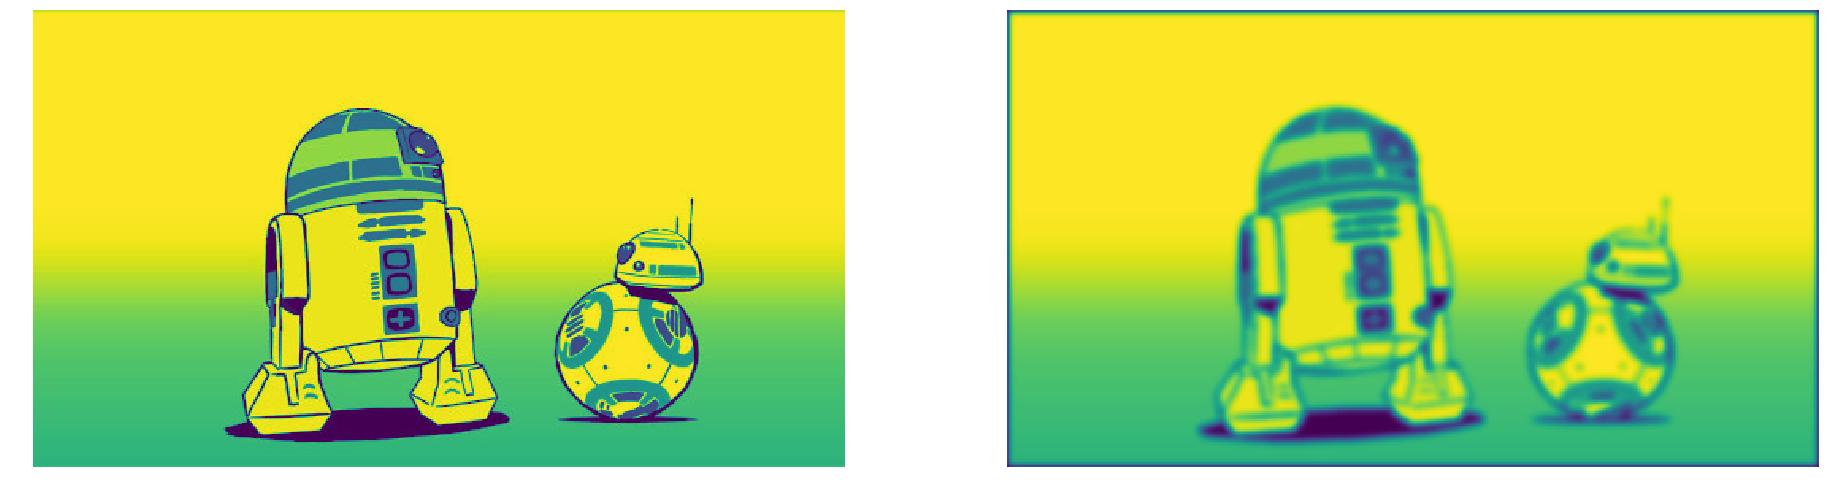

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

def display(orig, res):
    fig, axs = plt.subplots(1, 2, figsize=(32, 16))
    axs = axs.ravel()
    axs[0].axis('off')
    axs[0].imshow(orig)
    axs[1].axis('off')
    axs[1].imshow(res)

display(mono, t[0,0].detach().numpy())

To illustrate the effect of other 3x3 kernels, it is best to choose the kernel close to the "identity", and to apply it many times. Try the following:

weight Parameter containing:
tensor([[[[-0.0100,  0.0000,  0.0100],
          [-0.0200,  1.0000,  0.0200],
          [-0.0100,  0.0000,  0.0100]]]], requires_grad=True)


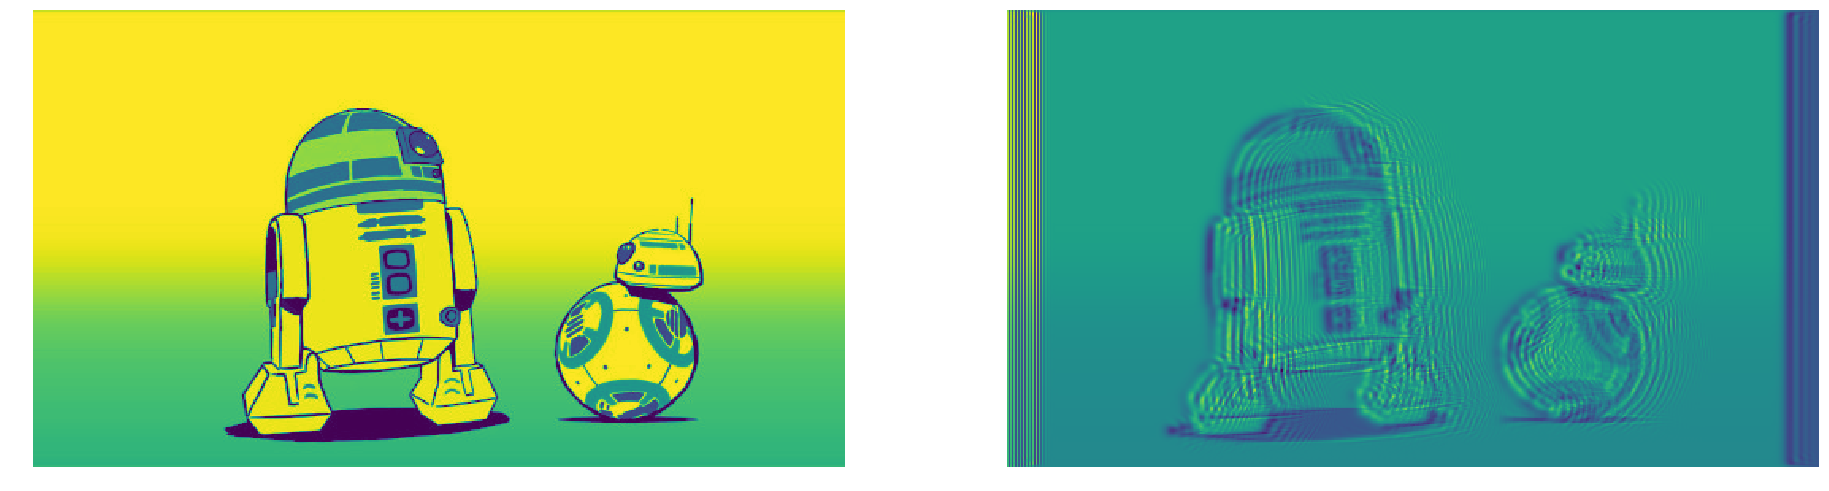

In [5]:
A = torch.Tensor([[-1,0,1],[-2,0,2],[-1,0,1]])
B = torch.Tensor([[1,2,1],[0,0,0],[-1,-2,-1]])
# These are the Sobel operator for edge detection (in traditional CV)
I = torch.Tensor([[0.,0,0],[0,1,0],[0,0,0]])
conv = nn.Conv2d(1,1,kernel_size=3,padding=1,bias=False)
conv.weight.data[:,:] = I + 0.01 * A  # or B
for name, param in conv.named_parameters():
    print(name, param)
    
t = torch.from_numpy(mono)
t = t[None,None,:,:].type(torch.float32)
for _ in range(300):
    t = conv(t)
display(mono, t[0,0].detach().numpy())

Do you see the image gets shifted in the *x*- or *y*-direction? What does it all mean? Without defining terms, one would like to say that 
> the operators `A` and `B` **generate** translations in the *x*- and *y*-directions.

You can also check for yourself that `A+B` generates translation in the 45 degree direction. Similarly, you can "mix up" translation with blurring. In fact, *any* 3x3 convolution is a combination of (tiny bits of) blurring, translations, and possibly other transformations. That's what convolution *does* to the whole image. By the way, this "wholistic" point of view has the advantage that one can now "picture" the entire CNN with the same standard picture of a neural net of nodes and edges: each node is now a whole image (or feature map), and each edge is a convolution operator. (insert image)

What is missing from such a convolutional operator is **rotation** and **scaling**, as it is well known that CNNs are not rotation/scale-invariant, inasmuch as it is translation-invariant. There have been attempts at making a neural network invariant or *equivariant* for rotation and scaling, but to my limited understanding they are rather more like "forced" fixes than modifying the convolutional layer itself. For people with the right kind of mathematical backgrounds, the solution may come immediately to mind: the **(infinitesimal) generators** for rotation and scaling (**Lie algebra** of a **Lie group**), or **flow** of a **vector field**, or solving a first-order linear partial differential equation by the **method of characteristics**.

Let me first show how the `conv_twist` works before we get back to explain the mathematics, as simply as I could (not using any of the jargon words above). Only then will we explain the details of the code.

## `conv_twist` at work (no training)

In addition to a standard Conv2d layer, the `conv_twist` is feeding the input to two other 3x3 Conv2d layer. To see the effect, let's turn off the `conv` weights

center_x Parameter containing:
tensor([0.], requires_grad=True)
center_y Parameter containing:
tensor([0.], requires_grad=True)
conv.weight Parameter containing:
tensor([[[[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]]]], requires_grad=True)
conv_x.weight Parameter containing:
tensor([[[[ 0.0100,  0.0200,  0.0100],
          [ 0.0000,  0.0000,  0.0000],
          [-0.0100, -0.0200, -0.0100]]]], requires_grad=True)
conv_y.weight Parameter containing:
tensor([[[[-0.0100,  0.0000,  0.0100],
          [-0.0200,  0.0000,  0.0200],
          [-0.0100,  0.0000,  0.0100]]]], requires_grad=True)


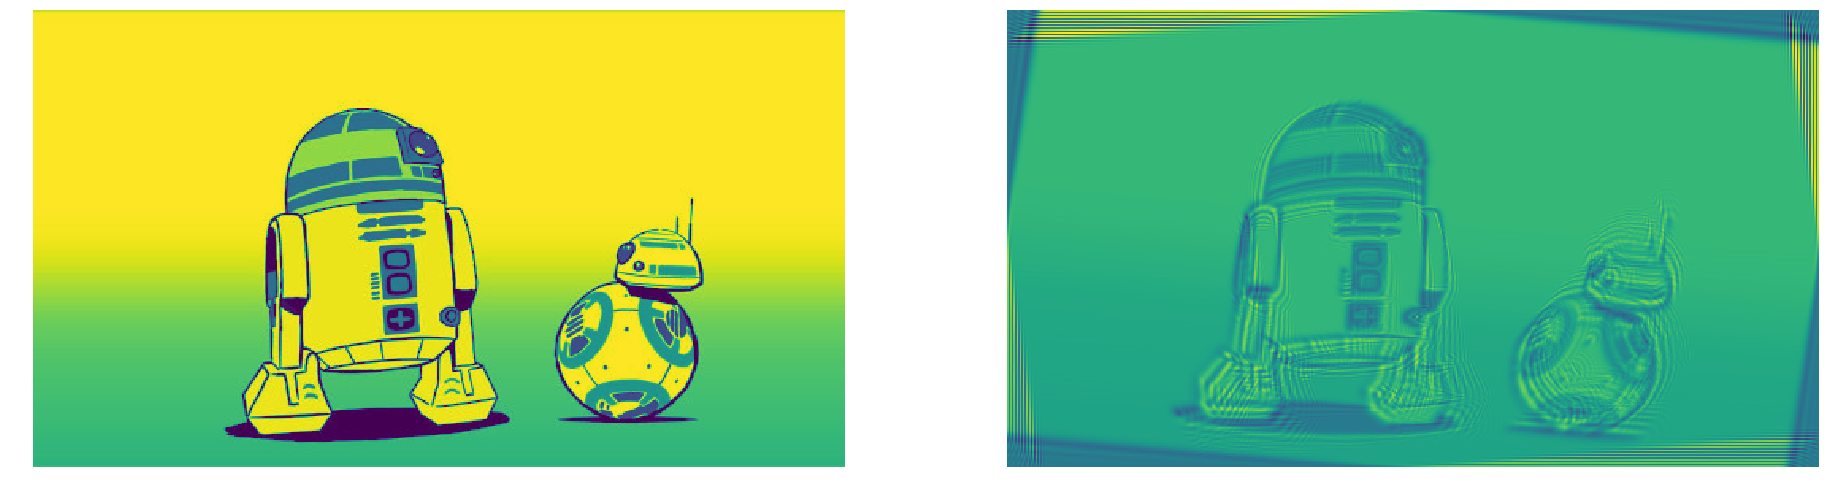

In [6]:
model = conv_twist(1,1)
model.conv.weight.data[:,:] = I
model.center_x.data[:] = 0
model.center_y.data[:] = 0
model.conv_x.weight.data[:,:] = 0.01 * B  # or -A
model.conv_y.weight.data[:,:] = 0.01 * A  # or B
for name, param in model.named_parameters():
    print(name, param)
    
t = torch.from_numpy(mono)
t = t[None,None,:,:].type(torch.float32)
for _ in range(300):
    t = model(t)
display(mono, t[0,0].detach().numpy())

## The math behind all this

There are various ways that one could discuss the pheonomenon of a "local operator", when applied many times, yields a global transformation. But the first step is invariably to think of the image *not* as a collection of **discrete** data (pixels) but as a **continuous** object (function of two variables), and the pixels are "samples" of the function that give a good approximation for computations that we want to perform on the function.

For functions of continuous variables, the first thing you might want to do is taking (partial) derivatives in the x- or y-direction. How would you approximate that if you don't have full information of the function, but only the samples at discrete points?

In [7]:
import numpy as np
print(np.indices((1,10,16))[1])
print(np.indices((1,10,16))[2])

[[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
  [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
  [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
  [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
  [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
  [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
  [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
  [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]]]
[[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]]]
